# Load Packages

In [1]:
import os
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download Dataset

In [3]:
# !wget https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
# !unzip -q captcha_images_v2.zip

# Preview Dataset

In [4]:
img_list = glob('/content/drive/MyDrive/bootcamp_project/captcha_images_v2_flip/*.png')

len(img_list)

1040

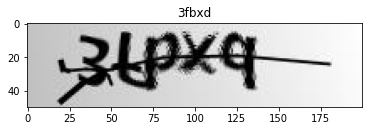

In [5]:
img = cv2.imread(img_list[0])

label = os.path.splitext(os.path.basename(img_list[0]))[0] # 확장자를 제외한 라벨명 추출

plt.title(label)
plt.imshow(img)

# Preprocessing

In [6]:
imgs = []
labels = []
max_length = 0

for img_path in img_list:
  imgs.append(img_path)

  label = os.path.splitext(os.path.basename(img_path))[0]
  labels.append(label)

  if len(label) > max_length:
    max_length = len(label)

print(len(imgs), len(labels), max_length) # 이미지수 / 라벨수 / 라벨글자수

1040 1040 5


In [7]:
''.join(labels)

'3fbxd3n2b43ebnn3ny453cpwb3ebpw3d7bd3eny73nw7w3n7mx3w2bw3mxdn3g2w63p4nn4cn7b4fp5g3ym7f4c8n84b2pw4dgf73x3254exnn3xng63ygde4cfw83x5fm3wnd34m2w54egem3ye2e4fc364dw3w4f8yp4gycb4gb3f4d22m3xcgg4n2yg4ycex5expp5dxnm5bnd74n3mn4nnf34w76g5bb664w6mw4yc854nc374ynf35bg8f5bgp25ep3n5n3w45pm6b5fyem5g5e55npdn5mgn45ng6e5p3mm5mcy75n2455mnpd5nxnn5mf7c5n7285mfff5xwcg5gcd35p8fm5wddw5f3gf5yxgp5x5nx5nnff5np4m5n7325ywwf5nggg5xd2e5x7x55nm6d6mege6fgdw6e6pn6cm6m6ecbn6b46g6fg8c6e5546bdn56dd2y6mygb6cwxe6e2dg6mn8n6fn846end36bxwg6dmx76ge3p6f8576f2yc6c3p56g45w6bnnm6b4w66gnm36c3n66m5eg6pfy46xxdx6p7gx6xen47b4bm6n5fd6ydyp6ng6w6p2ge6pwcn6wb766wnyc6n6gg7cdge6n4437bwm26wg4n6ng6n6xpme7bb7b7gp477cgym7m8px7dyww7fde77pcd77gnge7p8527gmf37gce67dgc27wn747dwx47d44m7dxbd7g3nf7nnnx7e2y77w67m7pn5g7fmcy7f8b37mgmf7yf628c23f8c2wy8db678d8ep8gmnx8cm468eggg8b7358fexn8bbw88e32m8gf7n7wyp47wnpm8gecm7y2x47xcyd7xd5m8d4wm8gmc48bbm48d2nd8g4yp8cccc8xef723n888n5pn24f6w8ypdn8npd58n62n8np228n2pg8n65n8wy7d8n4n88nbew8ne4g8npe38y63f8nn738w7548n5p38pfxx23md

In [8]:
characters = set(''.join(labels)) # 숫자, 스펠링 중복제거한 유니크값 추출_19개
characters

{'2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'm',
 'n',
 'p',
 'w',
 'x',
 'y'}

# Encode Labels

In [9]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)
# StringLookup = 글자를 숫자로 Incoding

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), num_oov_indices=0, mask_token=None, invert=True
)
# StringLookup의 invert = 숫자를 글자로 Decoding

print(labels[0])
encoded = char_to_num(tf.strings.unicode_split(labels[0], input_encoding='UTF-8'))
print(encoded) # 8 = 0 / p = 2 / f = 3 / x = 11로 인코딩

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


3fbxd
tf.Tensor([ 0 17  7  2  6], shape=(5,), dtype=int64)


In [10]:
tf.strings.reduce_join(num_to_char(encoded)).numpy().decode('utf-8')
# 0 / 2 / 3 / 11 / 11을 8pfxx로 디코딩

'3fbxd'

# Split Dataset

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(imgs, labels, test_size=0.2, random_state=42)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))

832 832
208 208


# Create Data Generator

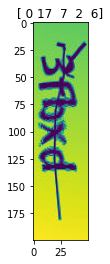

In [12]:
img_width = 200
img_height = 50

def encode_single_sample(img_path, label):
  # 1. Read image
  img = tf.io.read_file(img_path)

  # 2. Decode and convert to grayscale
  img = tf.io.decode_png(img, channels=1)

  # 3. Convert to float32 in [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)

  # 4. Resize to the desired size
  img = tf.image.resize(img, [img_height, img_width])

  # 5. Transpose the image because we want the time
  # dimension to correspond to the width of the image.
  img = tf.transpose(img, perm=[1, 0, 2])

  # 6. Map the characters in label to numbers
  label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
  
  # 7. Return a dict as our model is expecting two inputs
  return {'image': img, 'label': label}

preview = encode_single_sample(imgs[0], labels[0])

plt.title(str(preview['label'].numpy()))
plt.imshow(preview['image'].numpy().squeeze())

In [13]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = (
    val_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

print(train_dataset)
print(val_dataset)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


# Model

In [14]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name='image', dtype='float32'
    )
    labels = layers.Input(name='label', shape=(None,), dtype='float32')

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv1',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv2',
    )(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense_1')(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense_2'
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name='ctc_loss')(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name='ocr_model'
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']          

# Train

In [15]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=[early_stopping],
)

Epoch 1/500
26/26 [==============================] - 41s 749ms/step - loss: 23.5455 - val_loss: 16.3575
Epoch 2/500
26/26 [==============================] - 3s 107ms/step - loss: 16.3601 - val_loss: 16.3730
Epoch 3/500
26/26 [==============================] - 3s 110ms/step - loss: 16.3167 - val_loss: 16.3243
Epoch 4/500
26/26 [==============================] - 3s 109ms/step - loss: 16.3138 - val_loss: 16.3230
Epoch 5/500
26/26 [==============================] - 3s 110ms/step - loss: 16.3094 - val_loss: 16.3241
Epoch 6/500
26/26 [==============================] - 3s 112ms/step - loss: 16.3122 - val_loss: 16.3197
Epoch 7/500
26/26 [==============================] - 3s 108ms/step - loss: 16.3148 - val_loss: 16.3191
Epoch 8/500
26/26 [==============================] - 3s 132ms/step - loss: 16.3066 - val_loss: 16.3191
Epoch 9/500
26/26 [==============================] - 3s 107ms/step - loss: 16.3032 - val_loss: 16.3210
Epoch 10/500
26/26 [==============================] - 3s 106ms/step - lo

# Test Inference

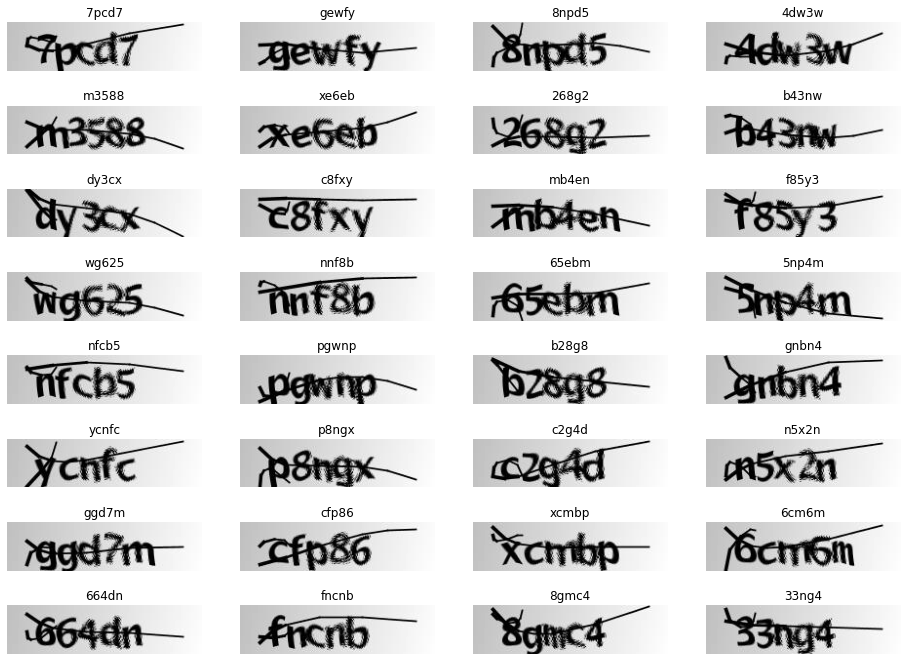

In [16]:
prediction_model = keras.models.Model(
  model.get_layer(name='image').input, model.get_layer(name='dense_2').output
)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

for batch in val_dataset.take(1):
    batch_images = batch['image']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, axes = plt.subplots(8, 4, figsize=(16, 12))

    for img, text, ax in zip(batch_images, pred_texts, axes.flatten()):
        img = img.numpy().squeeze()
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

        ax.imshow(img, cmap='gray')
        ax.set_title(text)
        ax.set_axis_off()

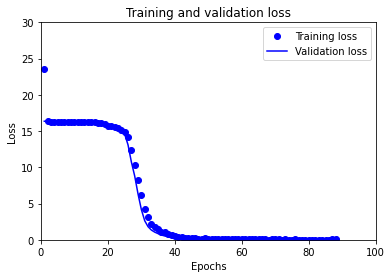

In [17]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.xlim([0, 100])
plt.ylim([0, 30])

plt.show()

In [18]:
# import joblib
# joblib.dump(history, './width_model.pkl')